In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
PROCESSED_FEATURES_DIR = "../processed_features"
SEQUENCE_LENGTH = 15
BATCH_SIZE = 128
HIDDEN_SIZE = 64
NUM_LAYERS = 2
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
CLASS_NAMES = ["awake", "light_drowsy", "severe_drowsy", "distracted"]
NUM_CLASSES = len(CLASS_NAMES)

In [4]:
class SequenceDataset(Dataset):
    """时间序列数据集"""

    def __init__(self, sequences, labels, augment=False):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = torch.LongTensor(labels)
        self.augment = augment

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # 训练时动态添加噪声
        if self.augment:
            noise = torch.randn_like(seq) * 0.02
            seq = seq + noise

        return seq, self.labels[idx]

In [5]:
class LSTMModel(nn.Module):
    """LSTM分类模型"""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM输出
        out, _ = self.lstm(x, (h0, c0))

        # 取最后一个时间步的输出
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [6]:
from collections import defaultdict
import random


def process_files_to_sequences(file_list, data_dir, seq_length):
    """读取文件列表并转换为序列数据"""
    sequences = []
    labels = []

    for filename in tqdm(file_list, desc="Processing files"):
        # 移除 .npy 后缀
        name_without_ext = filename[:-4]

        # 尝试匹配类别
        category = None
        for class_name in CLASS_NAMES:
            if name_without_ext.startswith(class_name):
                category = class_name
                break

        if category is None:
            continue

        label = CLASS_NAMES.index(category)

        # 加载特征
        features = np.load(os.path.join(data_dir, filename))

        # 滑动窗口生成序列
        for i in range(len(features) - seq_length + 1):
            seq = features[i : i + seq_length]
            sequences.append(seq)
            labels.append(label)

    return np.array(sequences), np.array(labels)


# ==========================================
# 核心修改:按类别+主体分组,确保原始和增强文件在同一集
# ==========================================

all_files = [f for f in os.listdir(PROCESSED_FEATURES_DIR) if f.endswith(".npy")]

# 第一步:按类别分组
files_by_class = defaultdict(list)
for f in all_files:
    for class_name in CLASS_NAMES:
        if f.startswith(class_name):
            files_by_class[class_name].append(f)
            break

# 第二步:在每个类别内部,按"主体"分组
train_files = []
test_files = []

for class_name, file_list in files_by_class.items():
    # 建立主体组字典
    subject_groups = defaultdict(list)

    for f in file_list:
        # 去掉类别前缀和.npy后缀,得到主体标识部分
        # 例如: awake_A_aug0.npy -> A_aug0 -> A
        # 例如: awake_aug5.npy -> aug5 -> (无主体,视为独立)
        base_name = f[len(class_name) + 1 : -4]  # 去掉 "awake_" 和 ".npy"

        if "_aug" in base_name:
            # 如果有 _aug,提取主体ID (aug前面的部分)
            subject_id = base_name.split("_aug")[0]
        else:
            subject_id = base_name  # 原始文件的主体ID

        # 特殊处理:如果没有主体ID (如 awake_aug5.npy -> subject_id=''),每个文件单独一组
        if subject_id == "":
            subject_groups[f].append(f)  # 用文件名本身作为组key
        else:
            subject_groups[subject_id].append(f)

    # 第三步:随机划分组 (80% train, 20% test)
    subject_keys = list(subject_groups.keys())
    random.seed(42)  # 固定随机种子保证可复现
    random.shuffle(subject_keys)

    split_idx = int(len(subject_keys) * 0.8)
    train_subjects = subject_keys[:split_idx]
    test_subjects = subject_keys[split_idx:]

    # 展开回文件列表
    for subject in train_subjects:
        train_files.extend(subject_groups[subject])

    for subject in test_subjects:
        test_files.extend(subject_groups[subject])

    print(
        f"{class_name}: 训练主体 {len(train_subjects)} 个, 测试主体 {len(test_subjects)} 个"
    )

print(f"\n总训练集文件数: {len(train_files)}")
print(f"总测试集文件数: {len(test_files)}")

# 生成序列数据
print("\n生成训练数据...")
X_train, y_train = process_files_to_sequences(
    train_files, PROCESSED_FEATURES_DIR, SEQUENCE_LENGTH
)
print("\n生成测试数据...")
X_test, y_test = process_files_to_sequences(
    test_files, PROCESSED_FEATURES_DIR, SEQUENCE_LENGTH
)

# 数据标准化
mean = X_train.mean(axis=(0, 1))
std = X_train.std(axis=(0, 1)) + 1e-6

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

np.save("normalization_params.npy", {"mean": mean, "std": std})

print(f"\n最终数据集形状:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

awake: 训练主体 18 个, 测试主体 5 个
distracted: 训练主体 47 个, 测试主体 12 个
light_drowsy: 训练主体 16 个, 测试主体 4 个
severe_drowsy: 训练主体 56 个, 测试主体 15 个

总训练集文件数: 254
总测试集文件数: 66

生成训练数据...


Processing files: 100%|██████████| 254/254 [00:00<00:00, 2405.40it/s]


生成测试数据...

Processing files: 100%|██████████| 66/66 [00:00<00:00, 2509.35it/s]



最终数据集形状:
X_train: (188529, 15, 7)
X_test: (55272, 15, 7)


In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in dataloader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        outputs = model(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100*correct / total

    return avg_loss, accuracy

In [8]:
def validate(model, dataloader, criterion, device):
    """验证模型"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100*correct / total

    return avg_loss, accuracy

In [9]:
# ==========================================
# 数据集统计信息
# ==========================================
print("\n=== 数据集统计 ===")
print(f"\n训练集:")
print(f"  样本数: {len(X_train)}")
print(f"  形状: {X_train.shape}")
train_labels_unique, train_counts = np.unique(y_train, return_counts=True)
for label_idx, count in zip(train_labels_unique, train_counts):
    print(f"  {CLASS_NAMES[label_idx]}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\n测试集:")
print(f"  样本数: {len(X_test)}")
print(f"  形状: {X_test.shape}")
test_labels_unique, test_counts = np.unique(y_test, return_counts=True)
for label_idx, count in zip(test_labels_unique, test_counts):
    print(f"  {CLASS_NAMES[label_idx]}: {count} ({count/len(y_test)*100:.1f}%)")

print(f"\n文件划分:")
print(f"  训练文件数: {len(train_files)}")
print(f"  测试文件数: {len(test_files)}")


=== 数据集统计 ===

训练集:
  样本数: 188529
  形状: (188529, 15, 7)
  awake: 46422 (24.6%)
  light_drowsy: 46924 (24.9%)
  severe_drowsy: 56093 (29.8%)
  distracted: 39090 (20.7%)

测试集:
  样本数: 55272
  形状: (55272, 15, 7)
  awake: 18060 (32.7%)
  light_drowsy: 12856 (23.3%)
  severe_drowsy: 17107 (31.0%)
  distracted: 7249 (13.1%)

文件划分:
  训练文件数: 254
  测试文件数: 66


使用设备: cuda

开始训练...
Epoch [1/20]
  Train Loss: 0.2590, Train Acc: 89.50%
  Val Loss: 0.5787, Val Acc: 80.93%
  保存最佳模型 (Val Acc: 80.93%)
Epoch [2/20]
  Train Loss: 0.1178, Train Acc: 95.27%
  Val Loss: 0.8097, Val Acc: 79.27%
Epoch [3/20]
  Train Loss: 0.0858, Train Acc: 96.62%
  Val Loss: 0.9027, Val Acc: 77.18%
Epoch [4/20]
  Train Loss: 0.0691, Train Acc: 97.35%
  Val Loss: 0.9303, Val Acc: 78.85%
Epoch [5/20]
  Train Loss: 0.0612, Train Acc: 97.72%
  Val Loss: 0.8818, Val Acc: 79.90%
Epoch [6/20]
  Train Loss: 0.0558, Train Acc: 97.97%
  Val Loss: 0.8049, Val Acc: 80.10%
Epoch [7/20]
  Train Loss: 0.0503, Train Acc: 98.12%
  Val Loss: 0.9322, Val Acc: 78.70%
  学习率调整: 0.001000 -> 0.000500
Epoch [8/20]
  Train Loss: 0.0399, Train Acc: 98.54%
  Val Loss: 0.9163, Val Acc: 79.80%
Epoch [9/20]
  Train Loss: 0.0385, Train Acc: 98.62%
  Val Loss: 0.8735, Val Acc: 80.47%
Epoch [10/20]
  Train Loss: 0.0374, Train Acc: 98.61%
  Val Loss: 0.8651, Val Acc: 80.47%
Epoch [11/20]
  Train Loss: 0.03

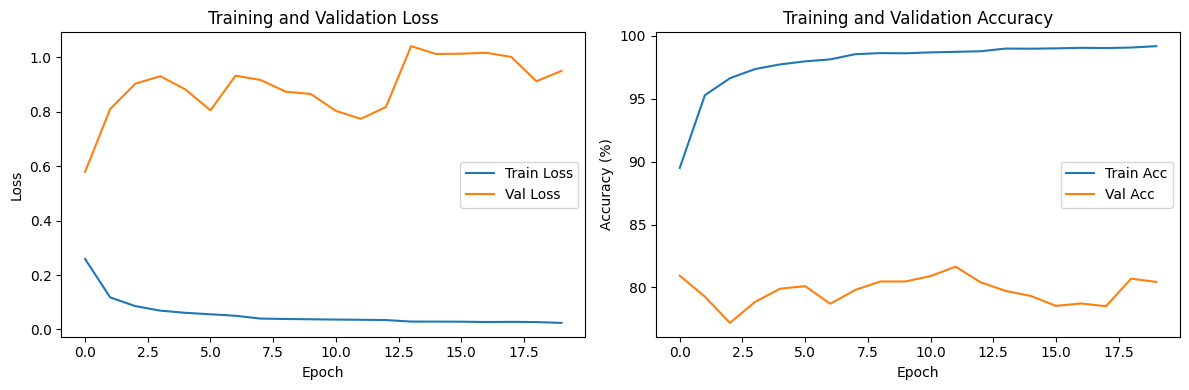

In [10]:
"""完整训练流程"""
print(f"使用设备: {DEVICE}")

# 3. 创建数据加载器
train_dataset = SequenceDataset(X_train, y_train, augment=True)
test_dataset = SequenceDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. 创建模型
input_size = X_train.shape[2]  # 特征维度
model = LSTMModel(input_size, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES,dropout=0.5).to(DEVICE)

# 5. 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# 6. 训练
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0

print(f"\n开始训练...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    val_loss, val_acc = validate(model, test_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
                "input_size": input_size,
                "hidden_size": HIDDEN_SIZE,
                "num_layers": NUM_LAYERS,
                "num_classes": NUM_CLASSES,
            },
            "best_lstm_model.pth",
        )
        print(f"  保存最佳模型 (Val Acc: {val_acc:.2f}%)")

    # 手动打印学习率变化
    old_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]["lr"]
    if old_lr != new_lr:
        print(f"  学习率调整: {old_lr:.6f} -> {new_lr:.6f}")

# 7. 绘制训练曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.tight_layout()
plt.show()

加载模型: best_lstm_model.pth
验证准确率: 81.65%
使用测试集样本数: 55272

分类报告:
               precision    recall  f1-score   support

        awake       0.94      0.66      0.78     18060
 light_drowsy       0.66      0.69      0.68     12856
severe_drowsy       0.79      1.00      0.88     17107
   distracted       0.96      1.00      0.98      7249

     accuracy                           0.82     55272
    macro avg       0.84      0.84      0.83     55272
 weighted avg       0.83      0.82      0.81     55272



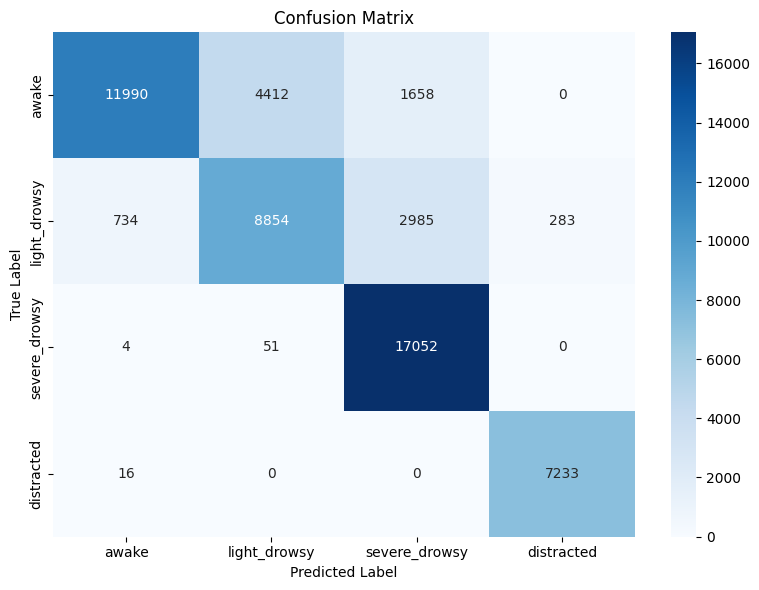

In [11]:
"""测试模型并计算详细指标"""
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 加载模型
model_path = "best_lstm_model.pth"
checkpoint = torch.load(model_path, map_location=DEVICE)
model = LSTMModel(
    checkpoint["input_size"],
    checkpoint["hidden_size"],
    checkpoint["num_layers"],
    checkpoint["num_classes"],
).to(DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"加载模型: {model_path}")
print(f"验证准确率: {checkpoint['val_acc']:.2f}%")

# ==========================================
# 修改点：直接使用之前按文件划分好的测试集
# 不要重新加载数据，也不要重新 train_test_split
# ==========================================
print(f"使用测试集样本数: {len(X_test)}")

test_dataset = SequenceDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 预测
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(DEVICE)
        outputs = model(sequences)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# 分类报告
print("\n分类报告:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

# 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

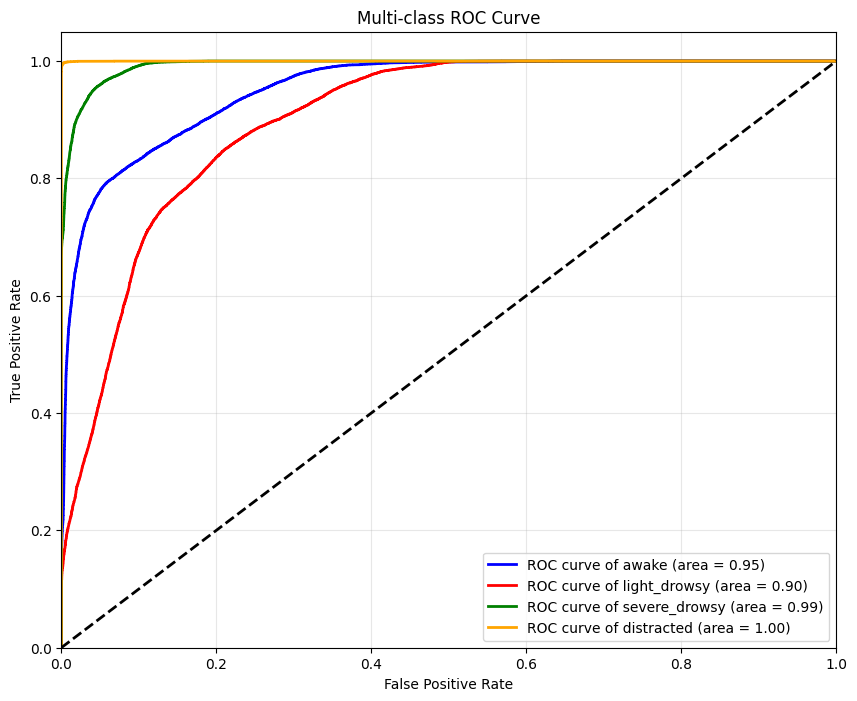

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import pandas as pd

# ==========================================
# 1. 绘制多分类 ROC 曲线
# ==========================================
# 将标签二值化
y_test_bin = label_binarize(all_labels, classes=range(NUM_CLASSES))
n_classes = y_test_bin.shape[1]
all_probs_np = np.array(all_probs)

# 计算每一类的ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
colors = ["blue", "red", "green", "orange"]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors[i],
        lw=2,
        label=f"ROC curve of {CLASS_NAMES[i]} (area = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

正在计算 t-SNE (可能需要一点时间)...


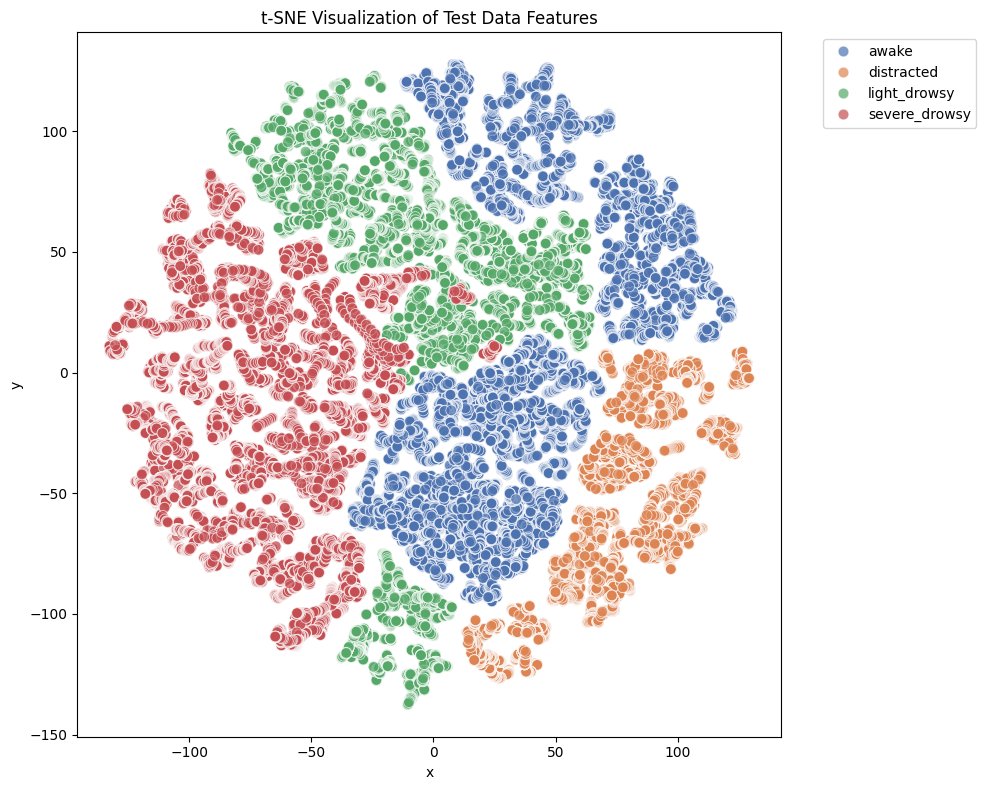

In [13]:
# ==========================================
# 2. t-SNE 特征可视化
# ==========================================
print("正在计算 t-SNE (可能需要一点时间)...")

# 为了可视化，我们将时间序列特征取平均值，从 (N, 15, Features) -> (N, Features)
# 这样可以看到在特征空间中，不同类别的样本是否聚集在一起
X_test_flat = X_test.mean(axis=1)

# 使用 t-SNE 降维到 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_test_flat)

# 创建 DataFrame 方便绘图
df_tsne = pd.DataFrame(X_embedded, columns=["x", "y"])
df_tsne["label"] = [CLASS_NAMES[i] for i in all_labels]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_tsne, x="x", y="y", hue="label", palette="deep", s=60, alpha=0.7
)
plt.title("t-SNE Visualization of Test Data Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

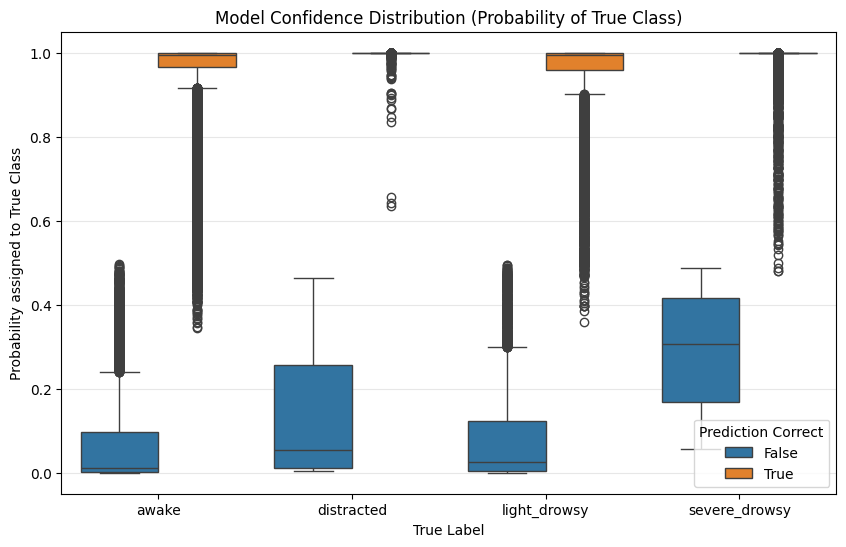

In [14]:
# ==========================================
# 3. 预测置信度分布 (Boxplot)
# ==========================================
# 查看模型对每个类别的预测概率分布情况
# 理想情况下，正确类别的概率应该很高
prob_df = pd.DataFrame(
    {
        "True Label": [CLASS_NAMES[i] for i in all_labels],
        "Predicted Probability": [
            probs[label] for probs, label in zip(all_probs, all_labels)
        ],
        "Prediction Correct": [p == l for p, l in zip(all_preds, all_labels)],
    }
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="True Label", y="Predicted Probability", hue="Prediction Correct", data=prob_df
)
plt.title("Model Confidence Distribution (Probability of True Class)")
plt.ylabel("Probability assigned to True Class")
plt.grid(True, axis="y", alpha=0.3)
plt.show()